# Success/Errors Histogram

In [39]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../')
from loaders import get_loader
from learners import get_learner
from utils import misc

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [41]:
# DEFINE HERE YOUR CONFIG PATH AND THE EPOCH YOU WANT TO EVALUATE
config_path = '/home/williamkeller/software/git/project_511/ConfidNet/confidnet/output_conf/config_1.yaml' 
ckpt_path = '/home/williamkeller/software/git/project_511/ConfidNet/confidnet/output_conf/model_epoch_005.ckpt'
config_args = misc.load_yaml(config_path)

In [42]:
# Get data loader
dloader = get_loader(config_args)
dloader.make_loaders()

2022-11-06 16:21:43,342 williamkeller-protectli confidnet.loaders.loader[10203] INFO --- Augmentations ---
2022-11-06 16:21:43,345 williamkeller-protectli confidnet.augmentations[10203] INFO Using No Augmentations
2022-11-06 16:21:43,381 williamkeller-protectli confidnet.loaders.loader[10203] WARNING Loading existing train-val split indices from ORIGINAL training


In [43]:
# Initialize and load model
learner = get_learner(config_args, dloader.train_loader, dloader.val_loader, dloader.test_loader, -1, device)
checkpoint = torch.load(ckpt_path)
learner.model.load_state_dict(checkpoint["model_state_dict"])

2022-11-06 16:21:45,460 williamkeller-protectli confidnet.learners.learner[10203] INFO Using optimizer sgd
2022-11-06 16:21:45,461 williamkeller-protectli confidnet.learners.learner[10203] INFO Using loss selfconfid_mse
2022-11-06 16:21:45,461 williamkeller-protectli confidnet.learners.selfconfid_learner[10203] INFO Freezing every layer except uncertainty
2022-11-06 16:21:45,462 williamkeller-protectli confidnet.learners.selfconfid_learner[10203] INFO Keeping original BN parameters


uncertainty1.weight kept to training
uncertainty1.bias kept to training
uncertainty2.weight kept to training
uncertainty2.bias kept to training
uncertainty3.weight kept to training
uncertainty3.bias kept to training
uncertainty4.weight kept to training
uncertainty4.bias kept to training
uncertainty5.weight kept to training
uncertainty5.bias kept to training


<All keys matched successfully>

In [44]:
def predict_test_set(learner, mode='normal', samples=50, verbose=True):
    accurate, errors, confidence = [], [], []
    loop = tqdm(learner.test_loader, disable=not verbose)
    for batch_id, (data, target) in enumerate(loop):
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            if mode == "normal":
                output = learner.model(data)
                conf, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)

            elif mode == "gt":
                output = learner.model(data)
                probs = F.softmax(output, dim=1)
                pred = probs.max(dim=1, keepdim=True)[1]
                labels_hot = misc.one_hot_embedding(target, learner.num_classes).to(device)
                # Segmentation special case
                if learner.task == "segmentation":
                    labels_hot = labels_hot.permute(0, 3, 1, 2)
                conf, _ = (labels_hot * probs).max(dim=1, keepdim=True)

            elif mode == "mc_dropout":
                if learner.task == "classification":
                    outputs = torch.zeros(samples, data.shape[0], learner.num_classes).to(device)
                elif learner.task == "segmentation":
                    outputs = torch.zeros(samples, data.shape[0], learner.num_classes, 
                                          data.shape[2], data.shape[3]).to(device)
                for i in range(samples):
                    outputs[i] = learner.model(data)
                output = outputs.mean(0)
                probs = F.softmax(output, dim=1)
                conf = (probs * torch.log(probs + 1e-9)).sum(dim=1)  # entropy
                pred = probs.max(dim=1, keepdim=True)[1]

            elif mode=='confidnet':
                output, conf = learner.model(data)
                pred = output.argmax(dim=1, keepdim=True)
                conf = torch.sigmoid(conf)

            accurate.extend(pred.eq(target.view_as(pred)))
            errors.extend(pred!=target.view_as(pred))
            confidence.extend(conf) 

    confidence = torch.stack(confidence).detach().to('cpu').numpy() .flatten()  
    accurate = torch.cat(accurate).detach().to('cpu').numpy().flatten()
    errors = torch.cat(errors).detach().to('cpu').numpy().flatten()
    ap_success = average_precision_score(accurate, confidence)
    ap_errors = average_precision_score(errors, -confidence)
    
    print(confusion_matrix(accurate, errors))

    return accurate, confidence, ap_success, ap_errors

In [46]:
accurate_normal, confidence_normal, _, _ = predict_test_set(learner, mode='confidnet')

  0%|          | 0/79 [00:00<?, ?it/s]

[[   0  711]
 [9289    0]]


In [48]:
accurate_gt, confidence_gt, _, _ = predict_test_set(learner, mode='confidnet')

  0%|          | 0/79 [00:00<?, ?it/s]

[[   0  685]
 [9315    0]]


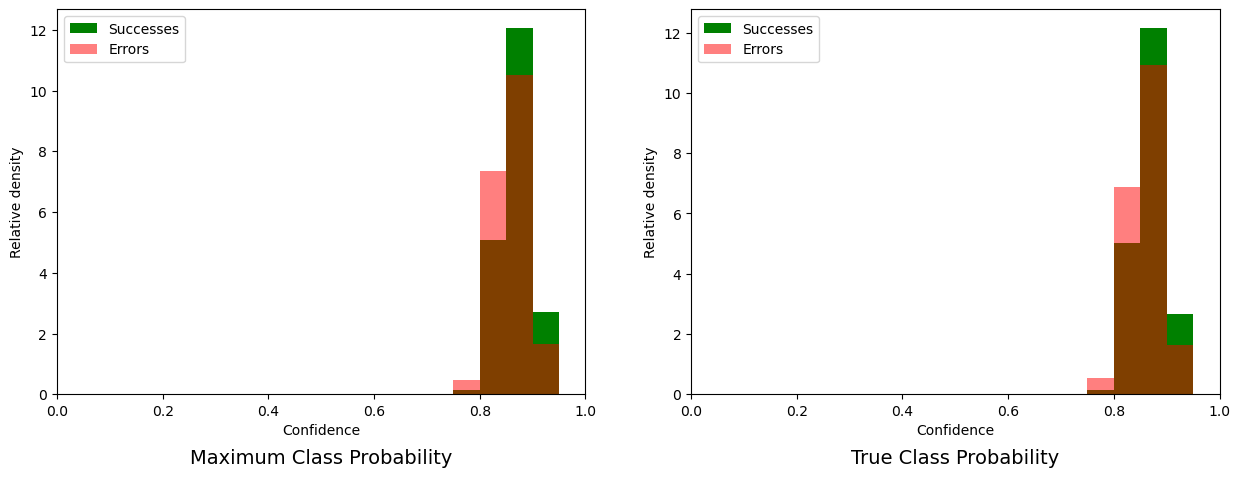

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Maximum Class Probability', y=-0.2, fontsize=14)
plt.hist(confidence_normal[np.where(accurate_normal==1)], 
         bins=np.linspace(0, 1,num=21), density=True, color='green',label='Successes')
plt.hist(confidence_normal[np.where(accurate_normal==0)], 
         bins=np.linspace(0, 1,num=21), density=True, alpha=0.5, color='red',label='Errors')
plt.xlabel('Confidence')
plt.ylabel('Relative density')
plt.xlim(left=0, right=1)
plt.legend()
plt.subplot(122)
plt.title('True Class Probability', y=-0.2, fontsize=14)
plt.hist(confidence_gt[np.where(accurate_gt==1)], 
         bins=np.linspace(0, 1,num=21), density=True, color='green',label='Successes')
plt.hist(confidence_gt[np.where(accurate_gt==0)], 
         bins=np.linspace(0, 1,num=21), density=True, alpha=0.5, color='red',label='Errors')
plt.xlabel('Confidence')
plt.ylabel('Relative density')
plt.xlim(left=0, right=1)
plt.legend()
plt.show()